<a href="https://colab.research.google.com/github/Bilal3099/ImageSegmentation/blob/main/FINALDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output as cls
!pip install tf_explain
cls()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf

# Data Loading
import tensorflow.data as tfd
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Models 
from keras.layers import ReLU
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization

# Re Trained Model
from tensorflow.keras.applications import ResNet50

# Model Visualization
from tensorflow.keras.utils import plot_model

# Callbacks 
from keras.callbacks import Callback, ModelCheckpoint

# Model Explaination
from tf_explain.core.grad_cam import GradCAM

In [ ]:
root_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/'

image_paths = glob(root_path + "*).png")
n_images = len(image_paths)

In [ ]:
print(n_images)

210


In [ ]:
def load_image(path, IMAGE_SIZE):
    image = img_to_array(load_img(path))
    image = tfi.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image

def load_data(image_paths, trim=None, IMAGE_SIZE=256, BATCH_SIZE=8, files=False):
    
    # Collect Paths
    if trim is not None:
        image_paths = image_paths[:trim]
    
    mask_paths = []
    for path in image_paths:
        mask_path = path.replace(".png", "_mask.png")
        mask_paths.append(mask_path)
    
    # Create Space
    images, masks = np.zeros(shape=(len(image_paths), IMAGE_SIZE, IMAGE_SIZE, 3)), np.zeros(shape=(len(image_paths), IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # Load Images
    for i, (image_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):
        image = load_image(image_path, IMAGE_SIZE=IMAGE_SIZE)
        mask  = load_image(mask_path, IMAGE_SIZE=IMAGE_SIZE)
        images[i] = image
        masks[i] = mask
    
    # Dataset
    data = tfd.Dataset.from_tensor_slices((images, masks))
    data = data.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)
    data = data.prefetch(tfd.AUTOTUNE)
    
    if files:
        return data, images, masks
    return data

In [ ]:
train_ds = load_data(image_paths, trim=170)
valid_ds, val_images, val_masks = load_data(image_paths, trim=40, files=True)

Loading: 170it [00:08, 19.08it/s]
Loading: 40it [00:00, 64.39it/s]


In [ ]:
def show_images(data, model=None, explain=False, n_images=6, SIZE=(25,10)):
    
    # Plot Configurations
    if model is not None:
        if explain:
            n_cols = 5
        else:
            n_cols = 4
    else:
        n_cols = 3
    
    # Iterate through data 
    for plot_no in range(1, n_images+1):
        for index, (images, masks) in enumerate(iter(data)):
            
            # Select Items 
            id = np.random.randint(len(images))
            image, mask = images[id], masks[id]
            
            if model is not None:
                
                if explain:
                    
                    # Make Prediction
                    pred_mask = model.predict(image[np.newaxis, ...])[0]
                    
                    # Grad CAM
                    cam = GradCAM()
                    cam = cam.explain(
                        validation_data=(val_images[id][np.newaxis,...], val_masks[id]),
                        model=model,
                        class_index=1,
                        layer_name="Top-ConvBlock-2",
                        image_weight=0.5
                    )
                    
                    # Figure
                    plt.figure(figsize=SIZE)

                    # Original Image
                    plt.subplot(1, n_cols, 1)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title("Original Image")

                    # Original Mask
                    plt.subplot(1, n_cols, 2)
                    plt.imshow(mask)
                    plt.axis('off')
                    plt.title('Original Mask')

                    # Predicted Mask
                    plt.subplot(1, n_cols, 3)
                    plt.imshow(pred_mask)
                    plt.axis('off')
                    plt.title("Predicted Mask")

                    # Mixed
                    plt.subplot(1, n_cols, 4)
                    plt.imshow(image)
                    plt.imshow(pred_mask, alpha=0.4)
                    plt.axis('off')
                    plt.title("Overlaped Prediction")
                    
                    # Mixed
                    plt.subplot(1, n_cols, 5)
                    plt.imshow(cam)
                    plt.axis('off')
                    plt.title("Grad CAM")

                    # Show Image
                    plt.show()
                    
                else:
                    # Make Prediction
                    pred_mask = model.predict(image[np.newaxis, ...])[0]

                    # Figure
                    plt.figure(figsize=SIZE)

                    # Original Image
                    plt.subplot(1, n_cols, 1)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title("Original Image")

                    # Original Mask
                    plt.subplot(1, n_cols, 2)
                    plt.imshow(mask)
                    plt.axis('off')
                    plt.title('Original Mask')

                    # Predicted Mask
                    plt.subplot(1, n_cols, 3)
                    plt.imshow(pred_mask)
                    plt.axis('off')
                    plt.title("Predicted Mask")

                    # Mixed
                    plt.subplot(1, n_cols, 4)
                    plt.imshow(image)
                    plt.imshow(pred_mask, alpha=0.4)
                    plt.axis('off')
                    plt.title("Overlaped Prediction")

                    # Show Image
                    plt.show()
                
            else:
                
                # Figure
                plt.figure(figsize=SIZE)
                
                # Original Image
                plt.subplot(1, n_cols, 1)
                plt.imshow(image)
                plt.axis('off')
                plt.title("Original Image")
                
                # Original Mask
                plt.subplot(1, n_cols, 2)
                plt.imshow(mask)
                plt.axis('off')
                plt.title('Original Mask')
                
                # Mixed
                plt.subplot(1, n_cols, 3)
                plt.imshow(image)
                plt.imshow(mask, alpha=0.4)
                plt.axis('off')
                plt.title("Overlaped Image")
                
                # Show Image
                plt.show()
            
            # Break Loop
            break

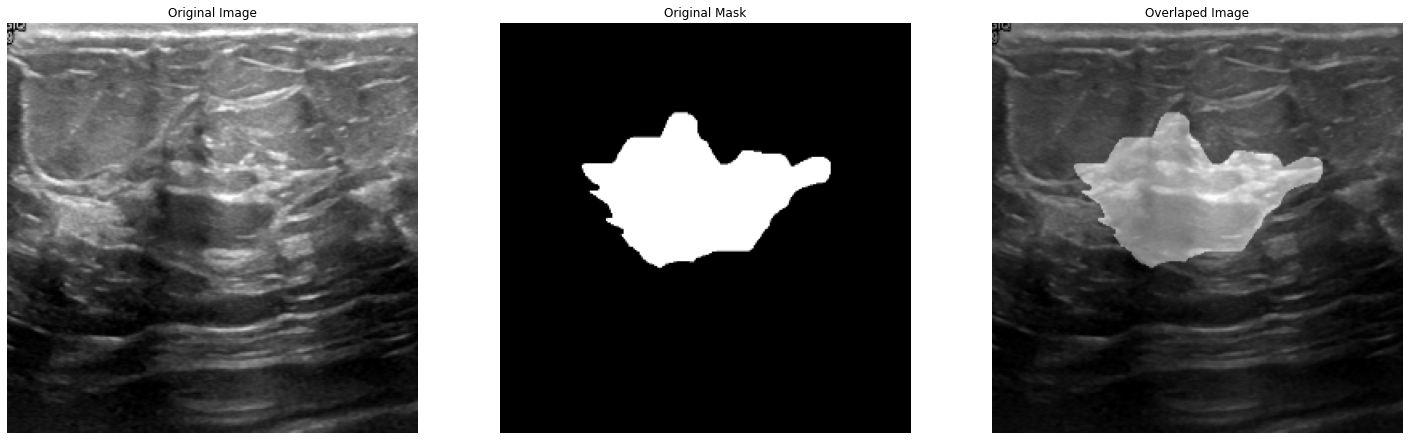

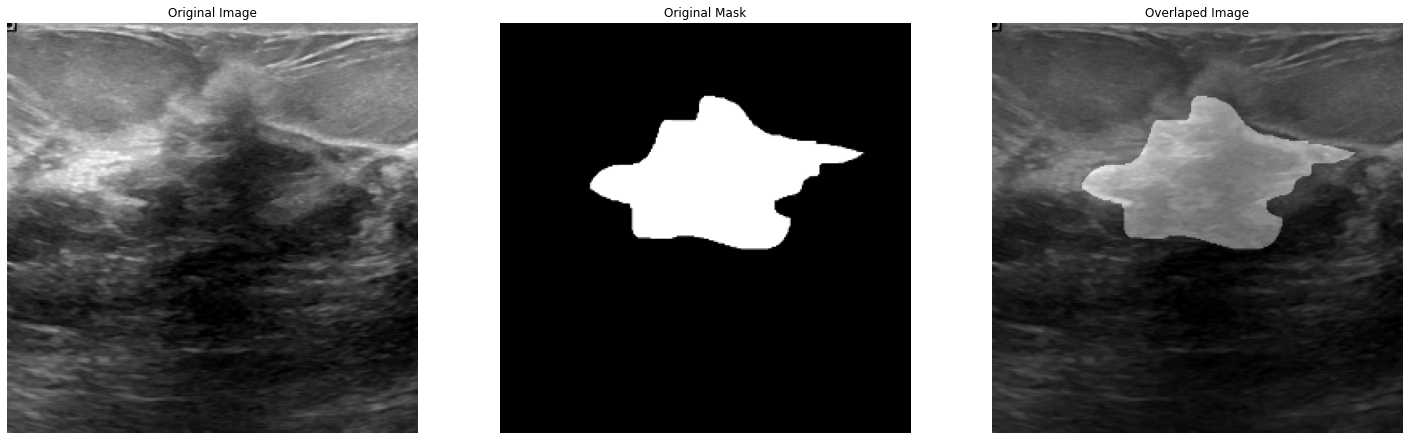

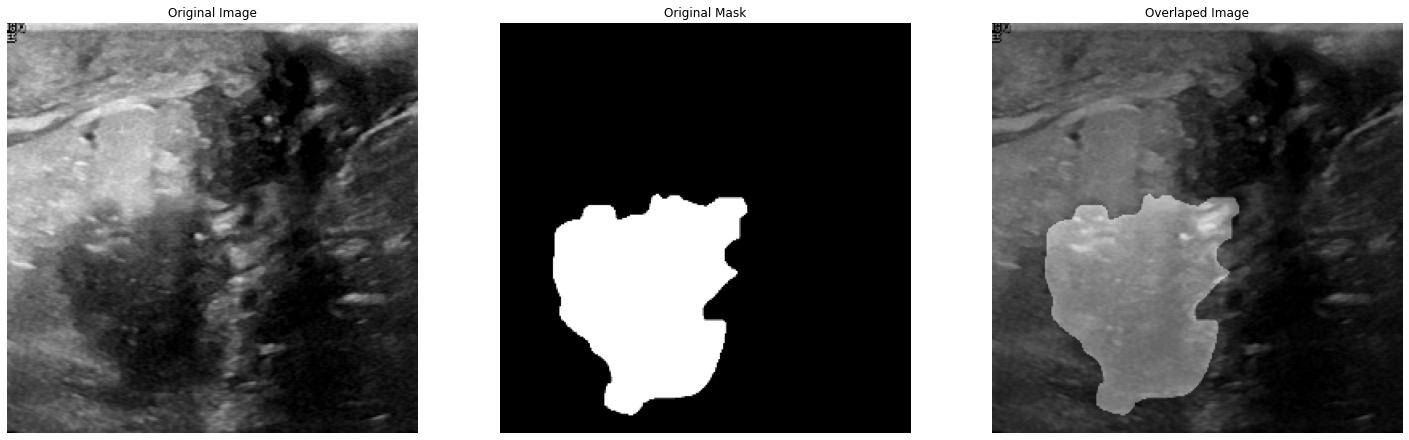

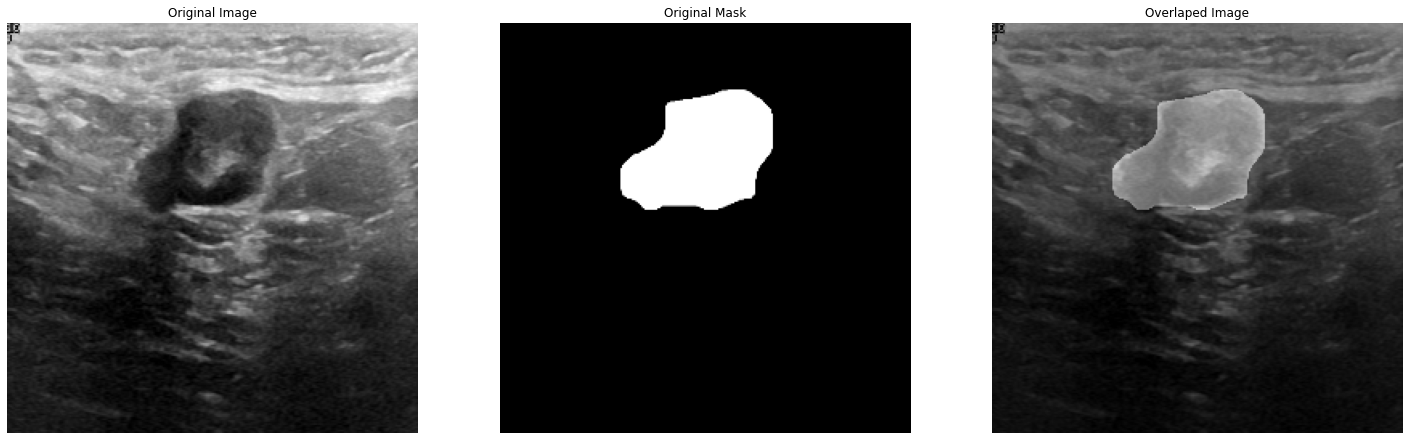

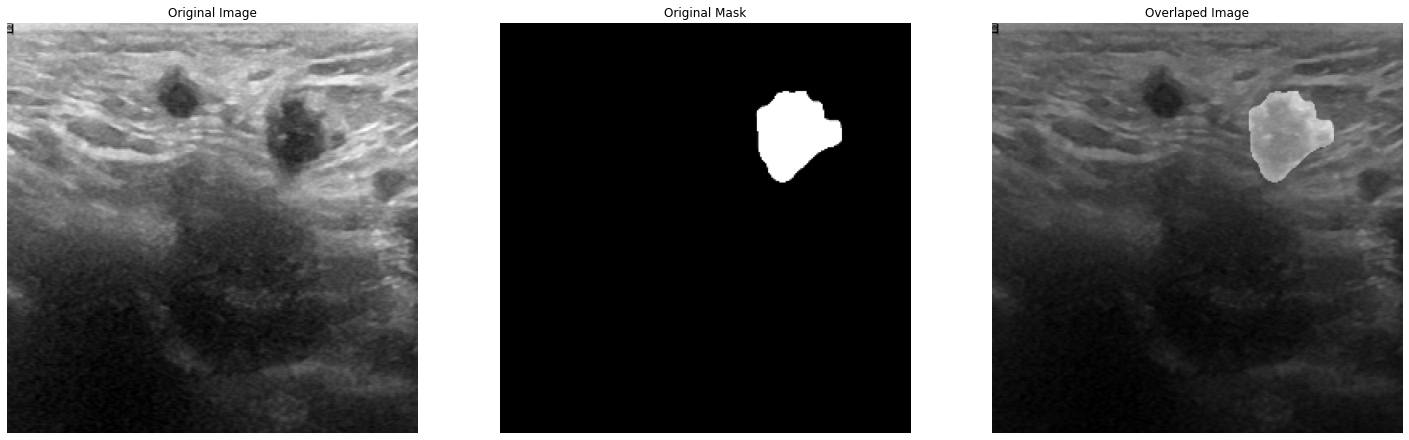

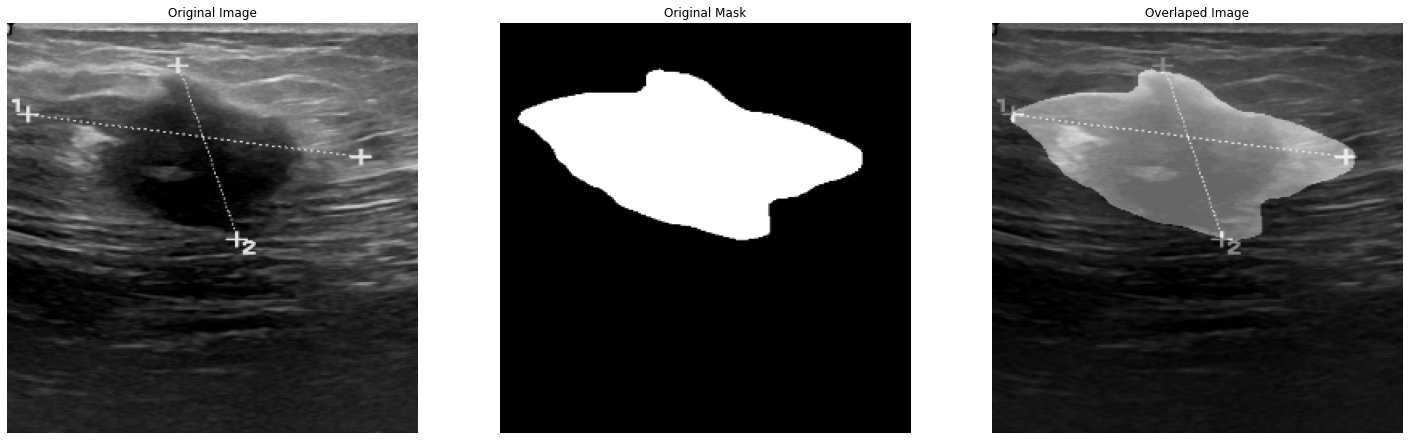

In [ ]:
show_images(data=train_ds)

In [ ]:
class ConvBlock(Layer):
    
    def __init__(self, filters=256, kernel_size=3, use_bias=False, dilation_rate=1, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_bias = use_bias
        self.dilation_rate = dilation_rate
        
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', dilation_rate=dilation_rate, use_bias=use_bias, kernel_initializer='he_normal'),
            BatchNormalization(),
            ReLU()
        ])
    
    def call(self, X): return self.net(X)        
        
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "use_bias":self.use_bias,
            "dilation_rate":self.dilation_rate
        }

In [ ]:
def AtrousSpatialPyramidPooling(X):
    
    # Shapes 
    _, height, width, _ = X.shape
    
    # Image Pooling 
    image_pool = AveragePooling2D(pool_size=(height, width), name="ASPP-AvgPool2D")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ConvBlock-1")(image_pool)
    image_pool = UpSampling2D(size=(height//image_pool.shape[1], width//image_pool.shape[2]), name="ASPP-UpSampling")(image_pool)
    
    # Conv Blocks
    conv_1 = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-Conv-1")(X)
    conv_6 = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-Conv-6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-Conv-12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-Conv-18")(X)
    
    # Concat All
    concat = Concatenate(axis=-1, name="ASPP-Concat")([image_pool, conv_1, conv_6, conv_12, conv_18])
    net = ConvBlock(kernel_size=1, name="ASPP-Net")(concat)
    
    return net

In [ ]:
LR = 1e-3
IMAGE_SIZE = 256

# Input
InputL = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")

# Base Mode
resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=InputL)

# ASPP Phase
DCNN = resnet50.get_layer('conv4_block6_2_relu').output
ASPP = AtrousSpatialPyramidPooling(DCNN)
ASPP = UpSampling2D(size=(IMAGE_SIZE//4//ASPP.shape[1], IMAGE_SIZE//4//ASPP.shape[2]), name="AtrousSpatial")(ASPP)

# LLF Phase
LLF = resnet50.get_layer('conv2_block3_2_relu').output
LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)

# Combined
combined = Concatenate(axis=-1, name="Combine-LLF-ASPP")([ASPP, LLF])
features = ConvBlock(name="Top-ConvBlock-1")(combined)
features = ConvBlock(name="Top-ConvBlock-2")(features)
upsample = UpSampling2D(size=(IMAGE_SIZE//features.shape[1], IMAGE_SIZE//features.shape[1]), interpolation='bilinear', name="Top-UpSample")(features)

# Output Mask
PredMask = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='sigmoid', use_bias=False, name="OutputMask")(upsample)

# DeelLabV3+ Model
model = Model(InputL, PredMask, name="DeepLabV3-Plus")
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "DeepLabV3-Plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['InputLayer[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                    

In [ ]:
from keras.metrics import MeanIoU

Epoch 1/30
21/21 [==============================] - 14s 461ms/step - loss: 0.0098 - accuracy: 0.5227 - IoU: 0.5254 - val_loss: 0.0188 - val_accuracy: 0.5649 - val_IoU: 0.5204
Epoch 2/30
21/21 [==============================] - 17s 818ms/step - loss: 0.0189 - accuracy: 0.5128 - IoU: 0.4426 - val_loss: 0.0204 - val_accuracy: 0.3609 - val_IoU: 0.4652
Epoch 3/30
21/21 [==============================] - 12s 592ms/step - loss: 0.0138 - accuracy: 0.4203 - IoU: 0.4351 - val_loss: 0.0108 - val_accuracy: 0.4686 - val_IoU: 0.4632
Epoch 4/30
21/21 [==============================] - 12s 565ms/step - loss: 0.0114 - accuracy: 0.5225 - IoU: 0.4513 - val_loss: 0.0121 - val_accuracy: 0.4445 - val_IoU: 0.4614
Epoch 5/30
1/1 [==============================] - 1s 796ms/step


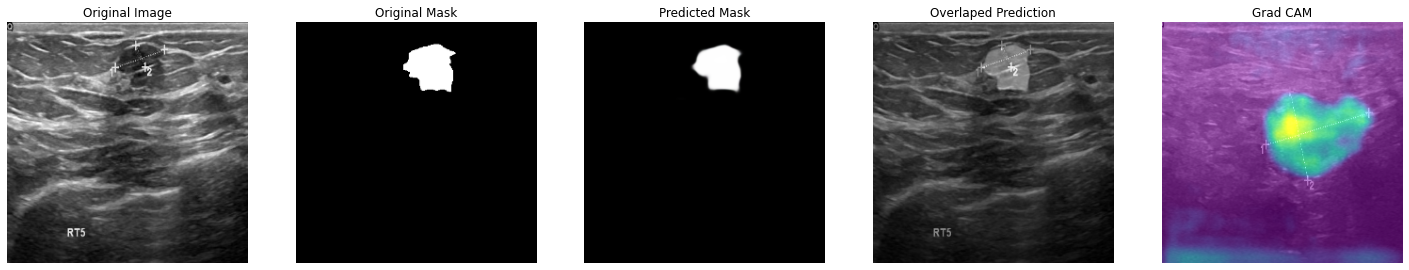

1/1 [==============================] - 0s 22ms/step


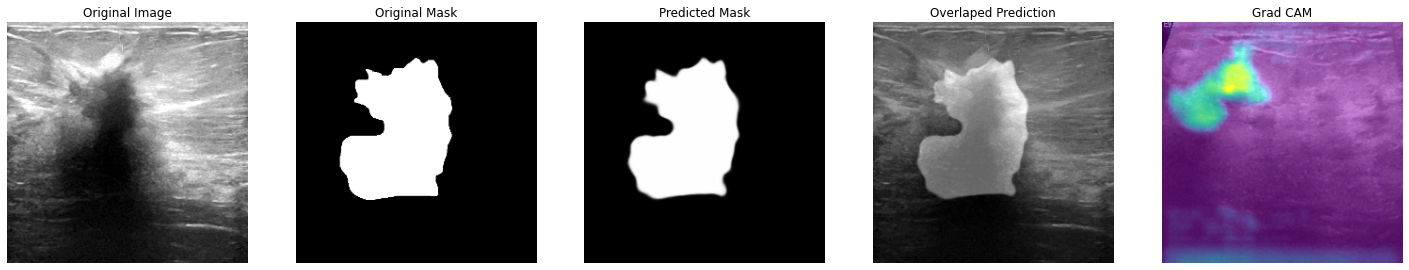

21/21 [==============================] - 13s 639ms/step - loss: 0.0115 - accuracy: 0.4544 - IoU: 0.4497 - val_loss: 0.0107 - val_accuracy: 0.3069 - val_IoU: 0.4458
Epoch 6/30
21/21 [==============================] - 8s 371ms/step - loss: 0.0104 - accuracy: 0.3977 - IoU: 0.4444 - val_loss: 0.0131 - val_accuracy: 0.3690 - val_IoU: 0.4619
Epoch 7/30
21/21 [==============================] - 9s 419ms/step - loss: 0.0097 - accuracy: 0.4841 - IoU: 0.4762 - val_loss: 0.0095 - val_accuracy: 0.4072 - val_IoU: 0.4663
Epoch 8/30
21/21 [==============================] - 8s 380ms/step - loss: 0.0094 - accuracy: 0.4781 - IoU: 0.4932 - val_loss: 0.0088 - val_accuracy: 0.3449 - val_IoU: 0.5083
Epoch 9/30
21/21 [==============================] - 8s 380ms/step - loss: 0.0094 - accuracy: 0.3885 - IoU: 0.4947 - val_loss: 0.0082 - val_accuracy: 0.3119 - val_IoU: 0.4811
Epoch 10/30
1/1 [==============================] - 0s 23ms/step


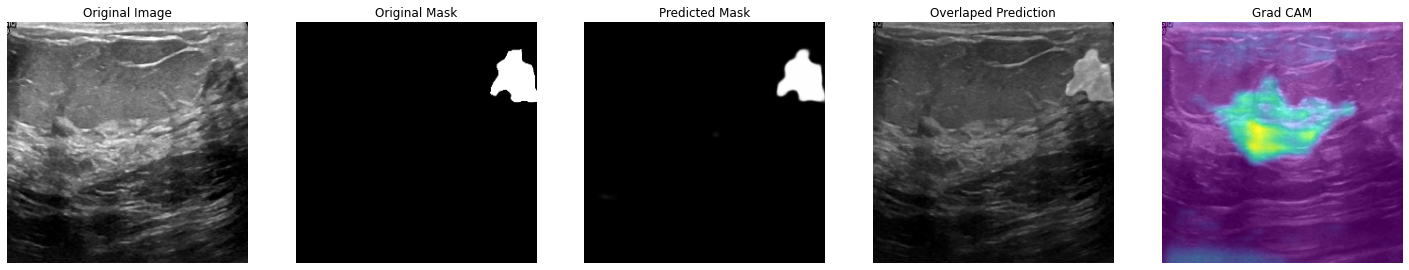

1/1 [==============================] - 0s 22ms/step


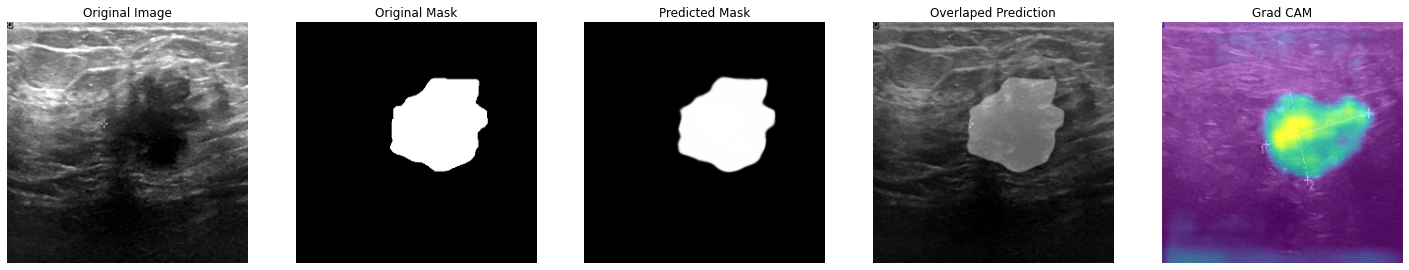

21/21 [==============================] - 9s 447ms/step - loss: 0.0090 - accuracy: 0.3707 - IoU: 0.5017 - val_loss: 0.0095 - val_accuracy: 0.3178 - val_IoU: 0.5004
Epoch 11/30
21/21 [==============================] - 7s 349ms/step - loss: 0.0085 - accuracy: 0.4110 - IoU: 0.5162 - val_loss: 0.0081 - val_accuracy: 0.3853 - val_IoU: 0.5229
Epoch 12/30
21/21 [==============================] - 8s 360ms/step - loss: 0.0080 - accuracy: 0.3920 - IoU: 0.5239 - val_loss: 0.0077 - val_accuracy: 0.3329 - val_IoU: 0.5324
Epoch 13/30
21/21 [==============================] - 8s 372ms/step - loss: 0.0077 - accuracy: 0.3976 - IoU: 0.5327 - val_loss: 0.0073 - val_accuracy: 0.4054 - val_IoU: 0.5469
Epoch 14/30
21/21 [==============================] - 7s 337ms/step - loss: 0.0075 - accuracy: 0.5072 - IoU: 0.5370 - val_loss: 0.0066 - val_accuracy: 0.4764 - val_IoU: 0.5886
Epoch 15/30
1/1 [==============================] - 0s 22ms/step


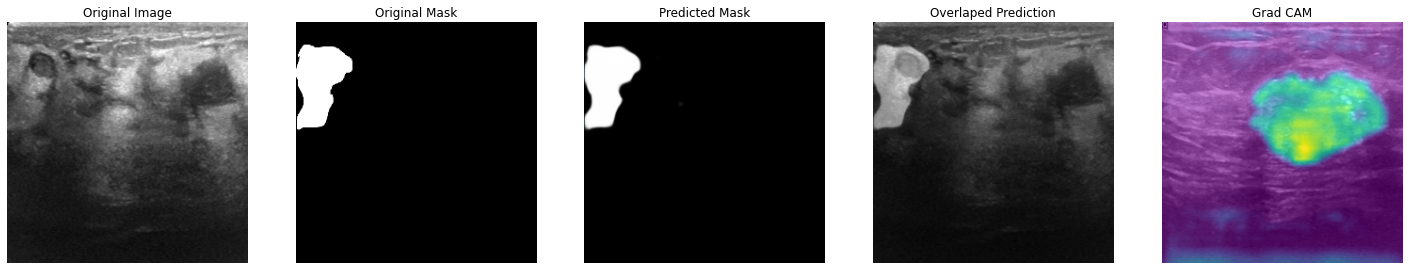

1/1 [==============================] - 0s 23ms/step


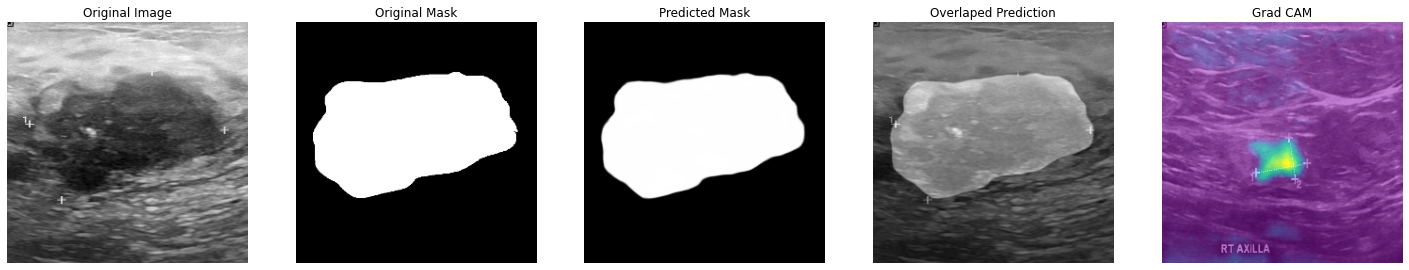

21/21 [==============================] - 9s 435ms/step - loss: 0.0072 - accuracy: 0.5190 - IoU: 0.5732 - val_loss: 0.0070 - val_accuracy: 0.4366 - val_IoU: 0.5577
Epoch 16/30
21/21 [==============================] - 8s 361ms/step - loss: 0.0075 - accuracy: 0.4593 - IoU: 0.5752 - val_loss: 0.0071 - val_accuracy: 0.4407 - val_IoU: 0.6070
Epoch 17/30
21/21 [==============================] - 8s 373ms/step - loss: 0.0073 - accuracy: 0.4447 - IoU: 0.5614 - val_loss: 0.0066 - val_accuracy: 0.4594 - val_IoU: 0.5547
Epoch 18/30
21/21 [==============================] - 8s 390ms/step - loss: 0.0071 - accuracy: 0.4904 - IoU: 0.5905 - val_loss: 0.0069 - val_accuracy: 0.4829 - val_IoU: 0.5735
Epoch 19/30
21/21 [==============================] - 8s 376ms/step - loss: 0.0069 - accuracy: 0.4927 - IoU: 0.5898 - val_loss: 0.0067 - val_accuracy: 0.4922 - val_IoU: 0.6139
Epoch 20/30
1/1 [==============================] - 0s 23ms/step


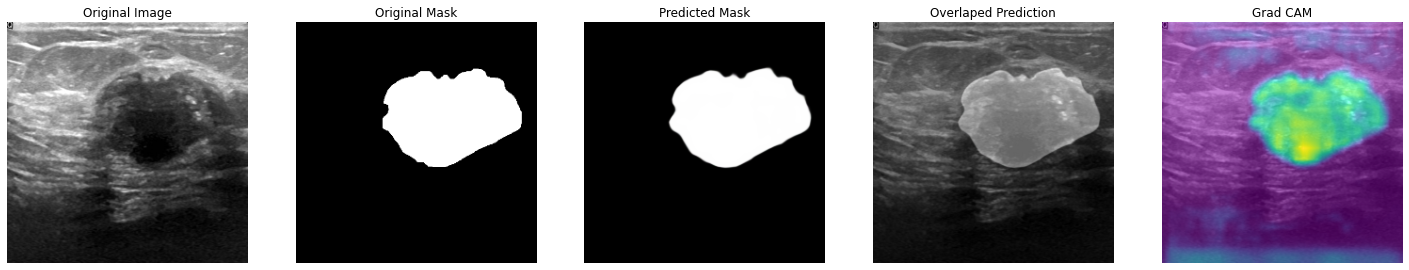

1/1 [==============================] - 0s 22ms/step


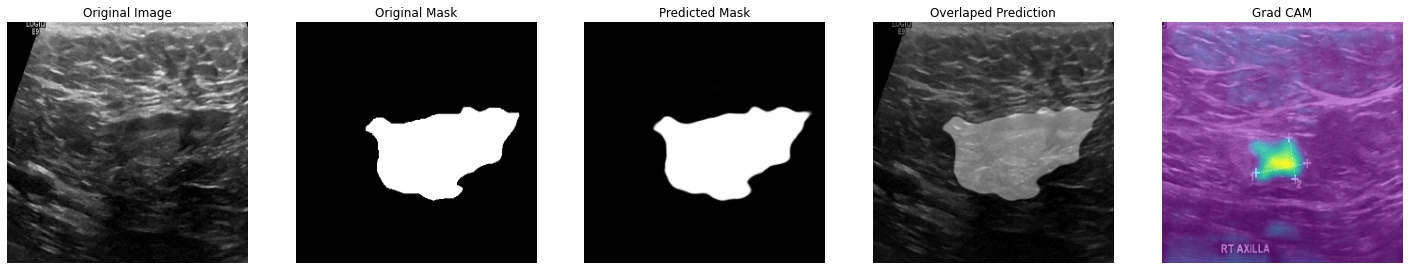

21/21 [==============================] - 8s 391ms/step - loss: 0.0067 - accuracy: 0.5129 - IoU: 0.5964 - val_loss: 0.0068 - val_accuracy: 0.5162 - val_IoU: 0.6431
Epoch 21/30
21/21 [==============================] - 7s 353ms/step - loss: 0.0066 - accuracy: 0.5390 - IoU: 0.6155 - val_loss: 0.0059 - val_accuracy: 0.5819 - val_IoU: 0.6636
Epoch 22/30
21/21 [==============================] - 7s 328ms/step - loss: 0.0066 - accuracy: 0.5321 - IoU: 0.6197 - val_loss: 0.0066 - val_accuracy: 0.4831 - val_IoU: 0.6929
Epoch 23/30
21/21 [==============================] - 7s 358ms/step - loss: 0.0066 - accuracy: 0.5504 - IoU: 0.6127 - val_loss: 0.0064 - val_accuracy: 0.5389 - val_IoU: 0.6516
Epoch 24/30
21/21 [==============================] - 7s 324ms/step - loss: 0.0066 - accuracy: 0.5313 - IoU: 0.6224 - val_loss: 0.0066 - val_accuracy: 0.5237 - val_IoU: 0.6566
Epoch 25/30
1/1 [==============================] - 0s 22ms/step


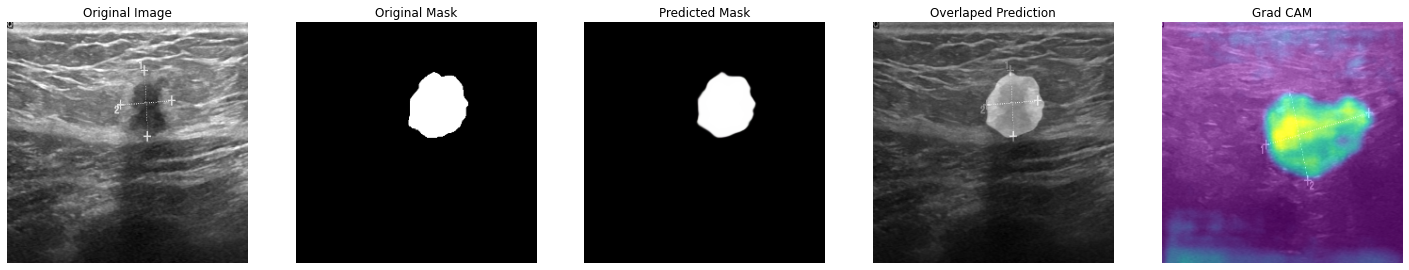

1/1 [==============================] - 0s 22ms/step


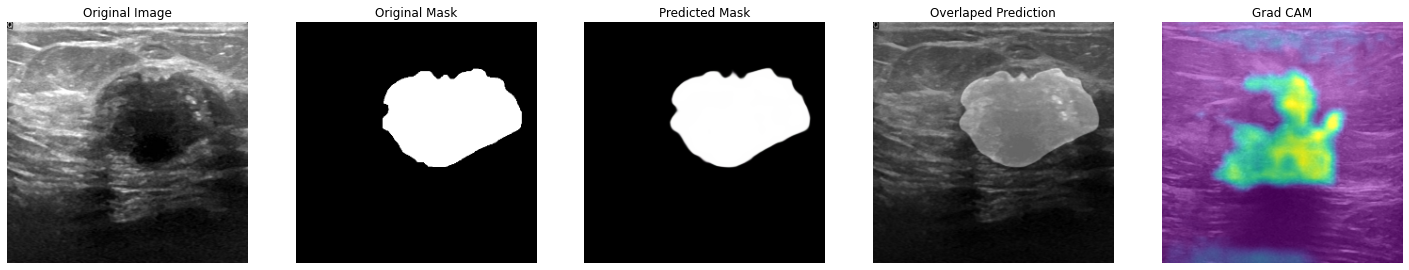

21/21 [==============================] - 9s 416ms/step - loss: 0.0072 - accuracy: 0.5126 - IoU: 0.6206 - val_loss: 0.0070 - val_accuracy: 0.5071 - val_IoU: 0.6567
Epoch 26/30
21/21 [==============================] - 7s 330ms/step - loss: 0.0073 - accuracy: 0.5524 - IoU: 0.5999 - val_loss: 0.0064 - val_accuracy: 0.5505 - val_IoU: 0.6479
Epoch 27/30
21/21 [==============================] - 7s 344ms/step - loss: 0.0068 - accuracy: 0.5694 - IoU: 0.6213 - val_loss: 0.0062 - val_accuracy: 0.4867 - val_IoU: 0.6919
Epoch 28/30
21/21 [==============================] - 7s 317ms/step - loss: 0.0067 - accuracy: 0.5151 - IoU: 0.6159 - val_loss: 0.0066 - val_accuracy: 0.5335 - val_IoU: 0.6625
Epoch 29/30
21/21 [==============================] - 7s 358ms/step - loss: 0.0064 - accuracy: 0.4769 - IoU: 0.6248 - val_loss: 0.0057 - val_accuracy: 0.5075 - val_IoU: 0.6814
Epoch 30/30
1/1 [==============================] - 0s 24ms/step


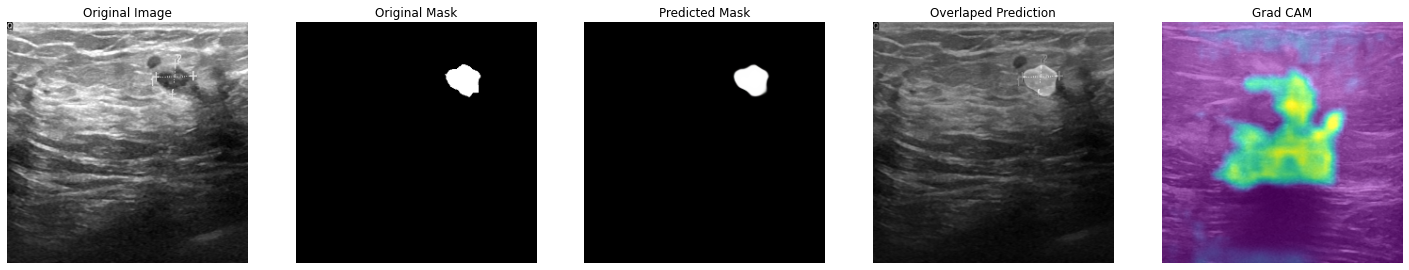

1/1 [==============================] - 0s 29ms/step


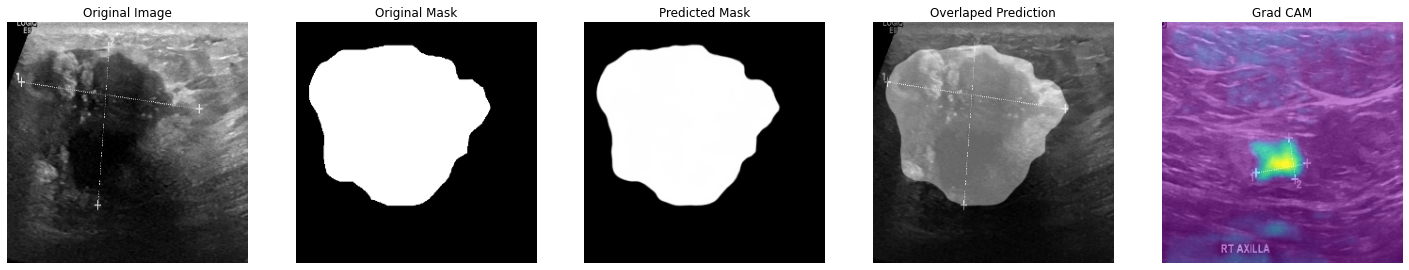

21/21 [==============================] - 8s 408ms/step - loss: 0.0060 - accuracy: 0.5233 - IoU: 0.6617 - val_loss: 0.0055 - val_accuracy: 0.6047 - val_IoU: 0.7209


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callback
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%5==0:
            show_images(valid_ds, model=self.model, explain=True, n_images=2, SIZE=(25,10))

# Callbacks
callbacks = [ModelCheckpoint("DeepLabV3-Plus.h5"), ShowProgress()]

# Training
results = model.fit(train_ds, validation_data=valid_ds, epochs=30, callbacks=callbacks)

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

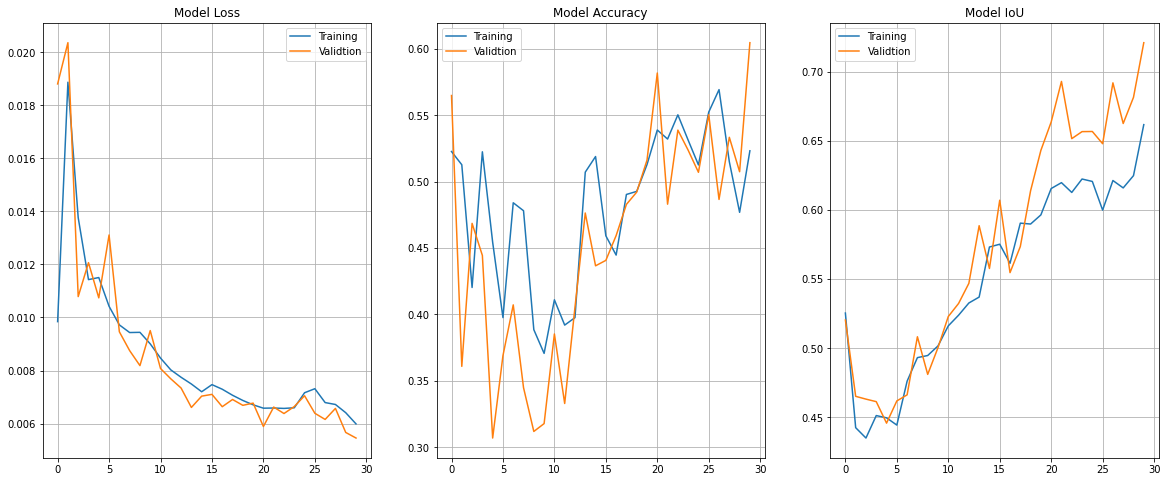

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

1/1 [==============================] - 0s 69ms/step


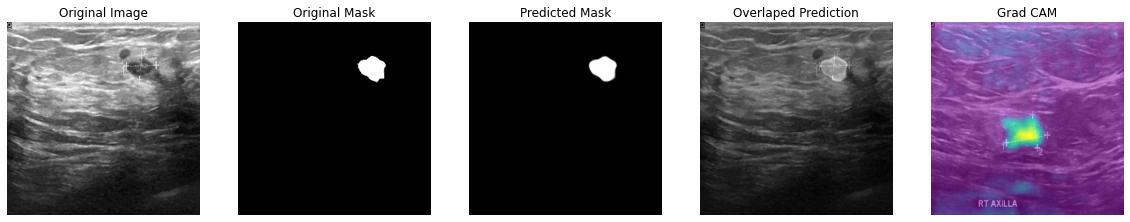

1/1 [==============================] - 0s 61ms/step


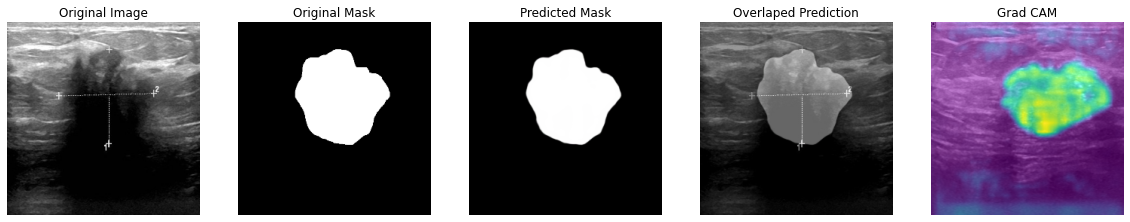

1/1 [==============================] - 0s 22ms/step


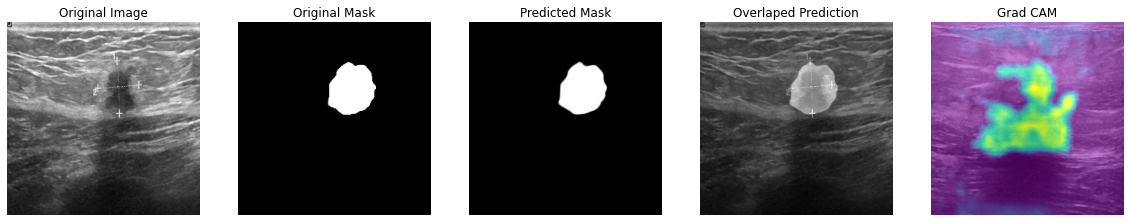

1/1 [==============================] - 0s 23ms/step


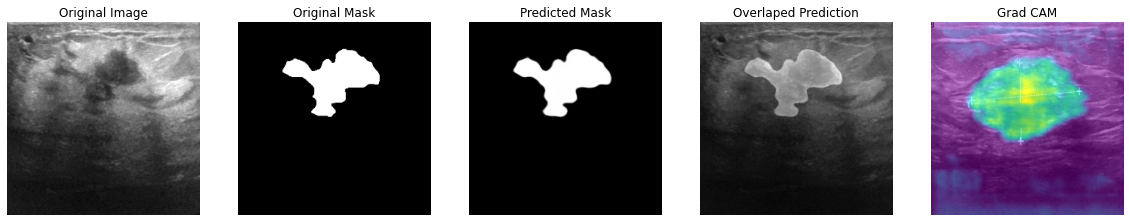

1/1 [==============================] - 0s 33ms/step


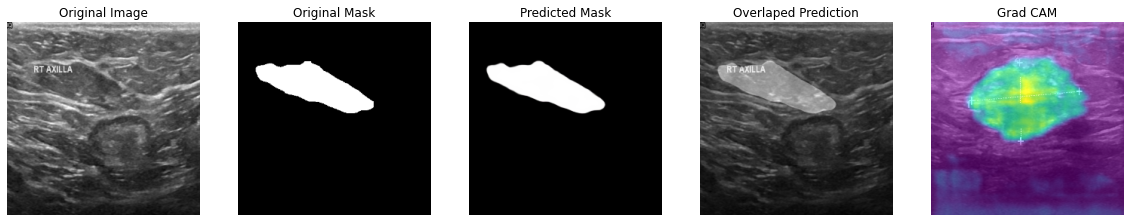

1/1 [==============================] - 0s 25ms/step


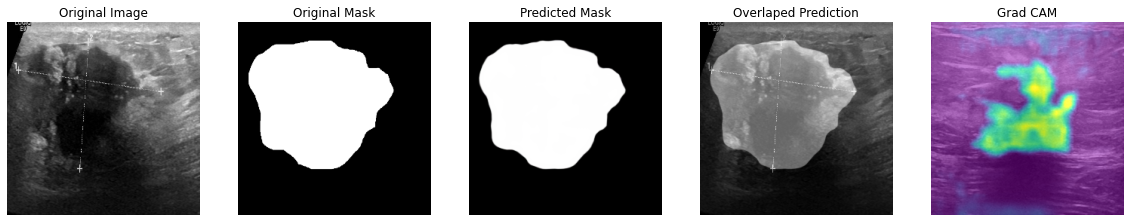

1/1 [==============================] - 0s 23ms/step


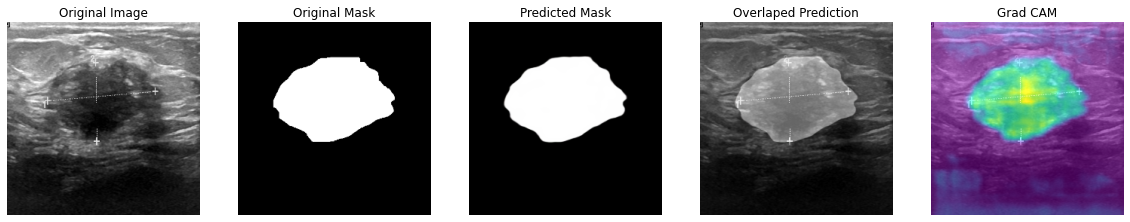

1/1 [==============================] - 0s 34ms/step


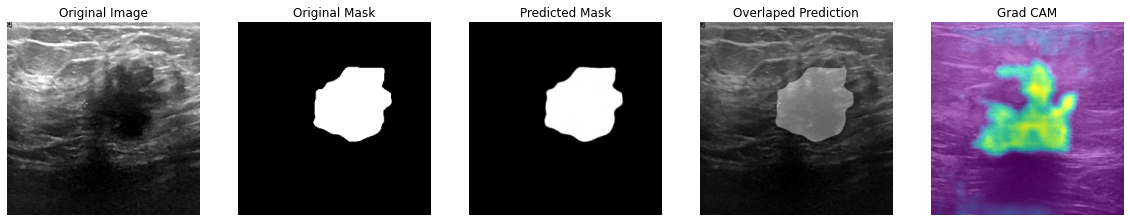

1/1 [==============================] - 0s 22ms/step


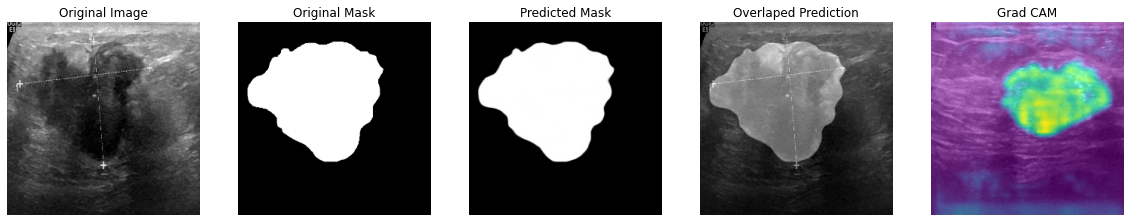

1/1 [==============================] - 0s 26ms/step


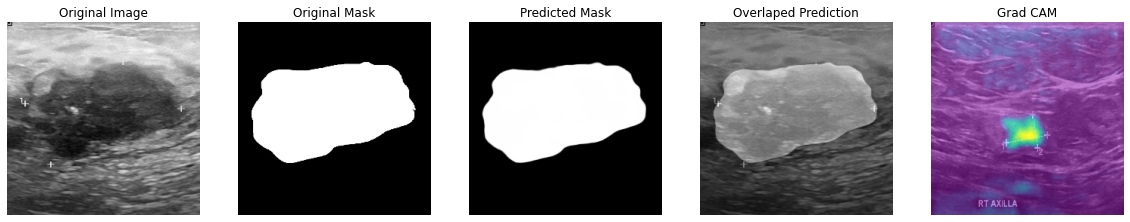

In [ ]:
show_images(valid_ds, model=model, explain=True, n_images=10, SIZE=(20,8))